# Building A Pricing Model For First Time Home Buyers

![King_County_WA](images/KingCountyWA.jpg)

# Overview

In this analysis, I inspect the King County House Sales dataset and iteratively develop a Multiple Regression model to analyze house prices.

# Business Problem

There are lots of residents in King County, Washington who are considering buying their first home. These prospective buyers could benefit immensely from being able to accurately forecast the price of their first home based on a set of given parameters. 

As an analyst for  DLG Real Estate Agency, I am tasked with developing a regression model to help my fellow employees determine which homes are best for their clients. 

# Importing Data, Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option("display.max_columns", 100)

In [4]:
df = pd.read_csv('data/kc_house_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Column Names and descriptions for Kings County Data Set
* **id** - Unique identifier for a house
* **date** - Date house was sold
* **price** - Price is prediction target
* **bedrooms** - Number of Bedrooms/House
* **bathrooms** - Number of bathrooms/bedrooms
* **sqft_living** - Square footage of the home
* **sqft_lot** - Square footage of the lot
* **floors** - Total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - score of view from house
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

Due to time constraints on this project, I am focusing solely on the following predictors: 

* bedrooms
* bathrooms 
* sqft_living
* sqft_lot
* floors
* waterfront
* condition
* grade
* yr_built
* zipcode
* view

Consequently, all other columns are dropped.

In [6]:
to_drop = ['date', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
df.drop(to_drop, axis=1, inplace=True)

# Basic Data Cleaning & Initial Model

Looking at the DataFrame information provided above, it appears that some columns have varying amounts of null values. Let's drop those and see if there are enough remaining entries for our analysis (at least 15,000). 

In [7]:
df.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19164 entries, 1 to 21596
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           19164 non-null  int64  
 1   price        19164 non-null  float64
 2   bedrooms     19164 non-null  int64  
 3   bathrooms    19164 non-null  float64
 4   sqft_living  19164 non-null  int64  
 5   sqft_lot     19164 non-null  int64  
 6   floors       19164 non-null  float64
 7   waterfront   19164 non-null  float64
 8   view         19164 non-null  float64
 9   condition    19164 non-null  int64  
 10  grade        19164 non-null  int64  
 11  yr_built     19164 non-null  int64  
 12  zipcode      19164 non-null  int64  
dtypes: float64(5), int64(8)
memory usage: 2.0 MB


In [9]:
df.head()

id      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
1  6414100192   538000.0         3       2.25         2570      7242     2.0   
2  5631500400   180000.0         2       1.00          770     10000     1.0   
3  2487200875   604000.0         4       3.00         1960      5000     1.0   
4  1954400510   510000.0         3       2.00         1680      8080     1.0   
5  7237550310  1230000.0         4       4.50         5420    101930     1.0   

   waterfront  view  condition  grade  yr_built  zipcode  
1         0.0   0.0          3      7      1951    98125  
2         0.0   0.0          3      6      1933    98028  
3         0.0   0.0          5      7      1965    98136  
4         0.0   0.0          3      8      1987    98074  
5         0.0   0.0          3     11      2001    98053

I now create a DataFrame **df_pred** containing only our predictors, dropping the *price* & *id* columns. 

In [10]:
df_pred = df.drop(['price', 'id'], axis=1)

Next, I take a look at the correlation between these features:

<AxesSubplot:>

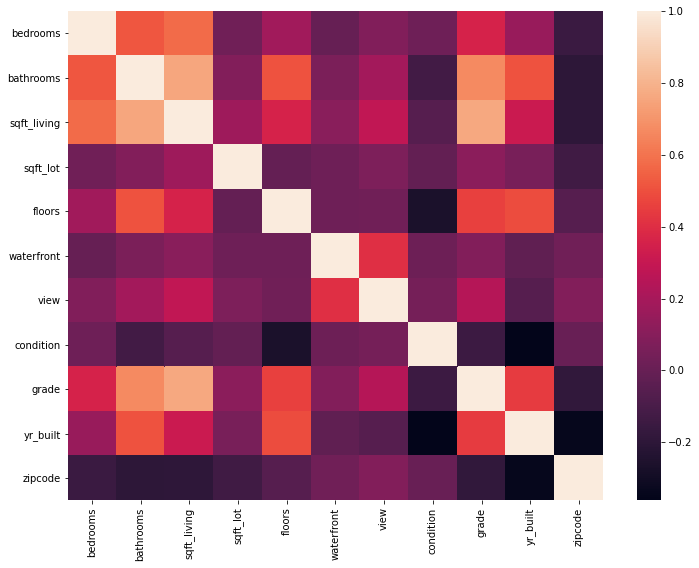

In [11]:
plt.figure(figsize=(12,9))
sns.heatmap(df_pred.corr())

In [12]:
corr_pair = df_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_pair['pairs'] = list(zip(corr_pair.level_0, corr_pair.level_1))
corr_pair.set_index(['pairs'], inplace = True)
corr_pair.drop(columns=['level_1', 'level_0'], inplace = True)
corr_pair.columns = ['cc']
corr_pair.drop_duplicates(inplace=True)

In [13]:
corr_pair[(corr_pair.cc>.75) & (corr_pair.cc <1)]

cc
pairs                             
(sqft_living, grade)      0.763701
(bathrooms, sqft_living)  0.755909

As seen in both the heatmap & new DataFrame **corr_pair**, the variables *sqft_living*, *grade*, & *bathrooms* are highly correlated (correlation coefficient having an absolute value of over 0.75, indicated on the heatmap by a light shade). 

In order to remove collinear features, I drop *grade* & *bathrooms*, leaving only the *sqft_living* predictor.

In [14]:
df_pred.drop(columns=['grade', 'bathrooms'], inplace=True)
df.drop(columns=['grade', 'bathrooms'], inplace=True)

Next, I inspect how the remaining predictors look when plotted individually against the dependent *price* variable in a scatterplot. 

These plots will be referenced again later on for any potential feature manipulation.

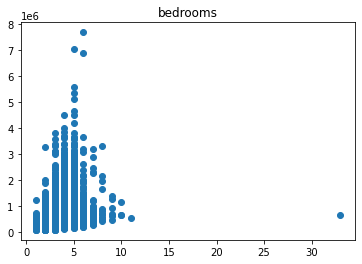

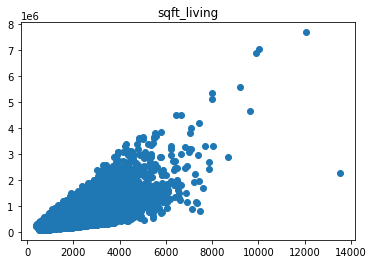

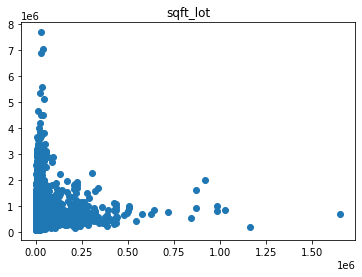

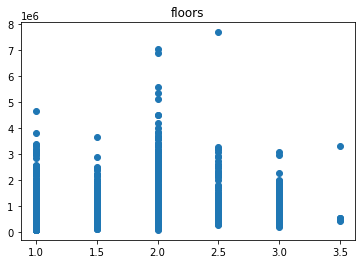

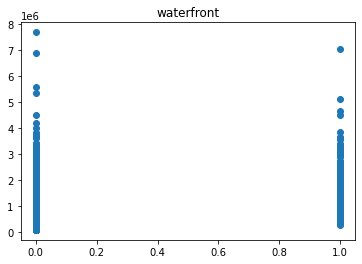

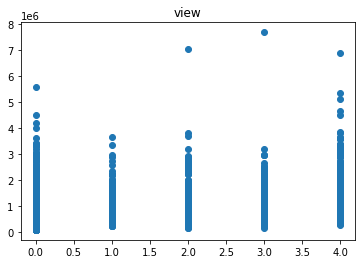

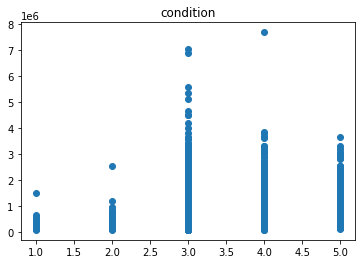

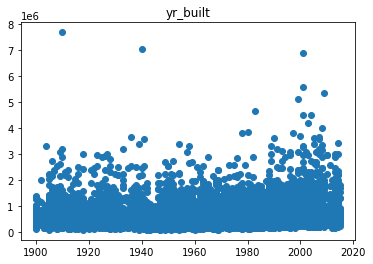

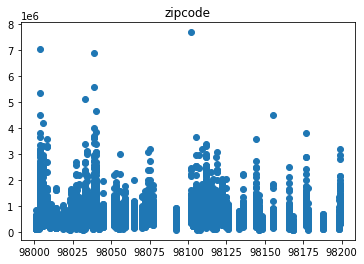

In [15]:
for col in df_pred.columns:
    plt.scatter(df_pred[col], df['price'])
    plt.title(col)
    plt.show()

I now run a baseline regression model using the above set of predictors, unchanged, before evaluating which features to change.

In [16]:
outcome = 'price'
x_cols = df_pred.columns
predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [17]:
model_1 = ols(formula=f, data=df).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     3149.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:58:50   Log-Likelihood:            -2.6424e+05
No. Observations:               19164   AIC:                         5.285e+05
Df Residuals:                   19154   BIC:                         5.286e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    6.454e+06   3.51e+06      1.836      0.066   -4.35e+05    1.33e+07
bedrooms    -5.209e+04   2279.762    -22.848      0.000   -5.66e+04   -4.76e+04
sqft_living   306.9798      2.606    117.804      0.000     301.872     312.087
sqft_lot       -0.3727      0.043     -8.681      0.000      -0.457      -0.289
floors       7.485e+04   3811.423     19.638      0.000    6.74e+04    8.23e+04
waterfront   5.634e+05   2.15e+04     26.174      0.000    5.21e+05    6.06e+05
view          5.94e+04   2586.549     22.965      0.000    5.43e+04    6.45e+04
condition    1.905e+04   2861.467      6.656      0.000    1.34e+04    2.47e+04
yr_built    -2494.5937     75.864    -32.883      0.000   -2643.293   -2345.895
zipcode       -16.8060     35.267     -0.477      0.634     -85.932      52.320
==============================================================================
Omnibus:                    11751.006   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           433493.239
Skew:                           2.378   Prob(JB):                         0.00
Kurtosis:                      25.809   Cond. No.                     2.05e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
data = df.copy()

y = data['price']
X = data.drop(['price', 'id'], axis = 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [21]:
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

Train MSE: 55152966172.65857
Test MSE: 56983648549.48906
RMSE Train: 234846.68652688837
RMSE Test: 238712.48092525254


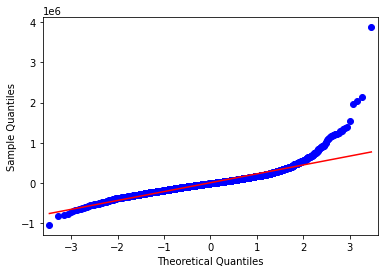

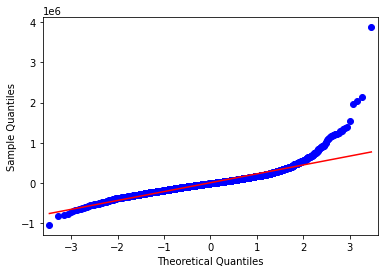

In [22]:
residuals = (y_test - y_hat_test)

sm.qqplot(residuals, line = "r")

This first model has an R-squared value of 0.597, and a Root Mean Square Error of around 240,000. Additionally, the residuals seem somewhat skewed based on the ends of the Q-Q Plot.

# Model 2: Dropping Outliers, Using Heuristics & Z-Scores

Now that a baseline model has been constructed to improve on, let's return to the initial business problem: creating a price-prediction model for first time home buyers. 

Recall the scatterplots constructed for the individual predictors against price. There are multiple features in the dataset with values that far exceed what would be found in a 'first home'. 

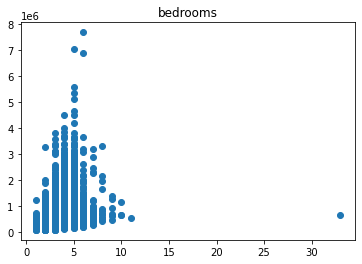

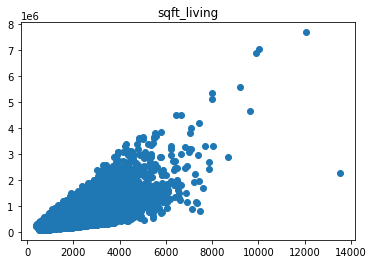

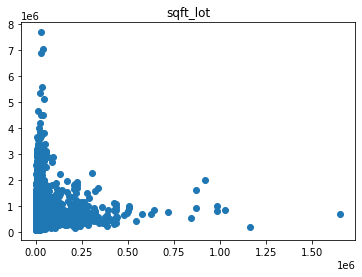

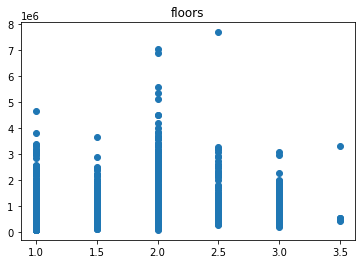

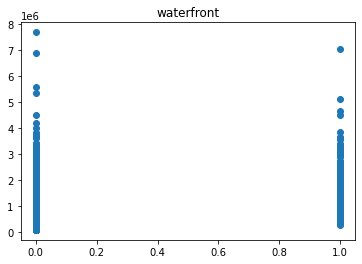

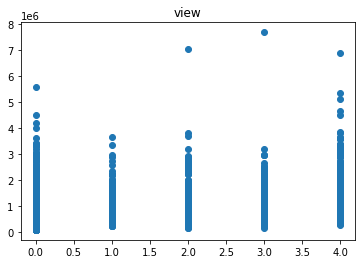

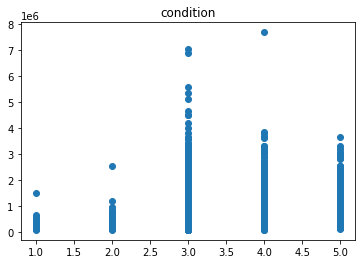

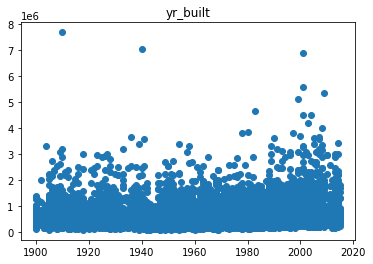

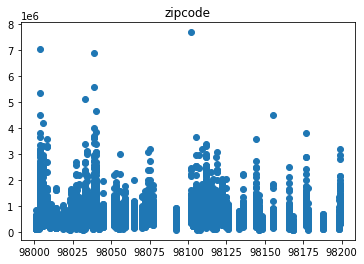

In [23]:
for col in df_pred.columns:
    plt.scatter(df_pred[col], df['price'])
    plt.title(col)
    plt.show()

## Dropping Data Using Heuristics

First, take a look at the *bedrooms* scatterplot. There is an obvious outlier home with 33 bedrooms, which is certainly unfeasible for any first time buyer. 

I begin by dropping this entry. 

In [24]:
df[df['bedrooms'] == 33]

id     price  bedrooms  sqft_living  sqft_lot  floors  \
15856  2402100895  640000.0        33         1620      6000     1.0   

       waterfront  view  condition  yr_built  zipcode  
15856         0.0   0.0          5      1947    98103

In [25]:
df.drop(labels=15856, axis=0, inplace=True)

Now, I inspect the *bedrooms* column. 

In [26]:
df.sort_values(by=['bedrooms'], axis=0, ascending=False)

id      price  bedrooms  sqft_living  sqft_lot  floors  \
8748   1773100755   520000.0        11         3000      4960     2.0   
13301   627300145  1150000.0        10         4590     10920     1.0   
19239  8812401450   660000.0        10         2920      3745     2.0   
15147  5566100170   650000.0        10         3610     11914     2.0   
4092   1997200215   599999.0         9         3830      6988     2.5   
...           ...        ...       ...          ...       ...     ...   
648     922049078   157000.0         1          870     26326     1.0   
7368   7228501903   250000.0         1          780      1033     1.0   
3380   8807900236   430000.0         1          630      1362     1.0   
18261  2781600195   285000.0         1         1060     54846     1.0   
17282  4047200825   400000.0         1         1390     60984     1.0   

       waterfront  view  condition  yr_built  zipcode  
8748          0.0   0.0          3      1918    98106  
13301         0.0   2.0          3      2008    98004  
19239         0.0   0.0          4      1913    98105  
15147         0.0   0.0          4      1958    98006  
4092          0.0   0.0          3      1938    98103  
...           ...   ...        ...       ...      ...  
648           0.0   0.0          3      1939    98198  
7368          0.0   0.0          3      1922    98122  
3380          0.0   0.0          3      1943    98109  
18261         1.0   4.0          3      1935    98070  
17282         0.0   0.0          3      1960    98019  

[19163 rows x 11 columns]

<AxesSubplot:>

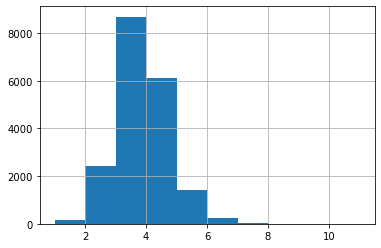

In [27]:
df['bedrooms'].hist()

Even if a potential first time buyer is a large family in need of more rooms than usual, it is difficult to envision such a client needing any more than 8 bedrooms. 

In [28]:
df = df[df['bedrooms'] < 9]

<AxesSubplot:>

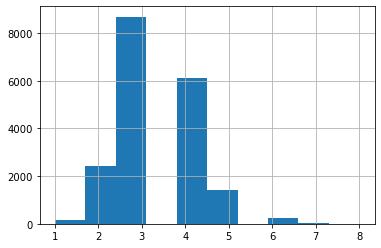

In [29]:
df['bedrooms'].hist()

## Dropping Data Using Z-Scores of Continuous Variables

<AxesSubplot:>

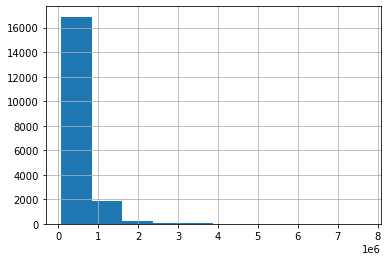

In [30]:
df['price'].hist()

In [31]:
mean_price = df['price'].mean()
std3_price = 3*df['price'].std()
print(mean_price - std3_price, mean_price + std3_price)

-571334.4145640415 1653916.1387847904


From the histogram of home prices, we can tell that none of the prices fall more than 3 standard deviations below the mean price (given by the interval above). There are, however, outlying prices more than 3 standard deviations above the mean. I elect to filter these homes out of the dataset.

In [32]:
upper_price = mean_price + std3_price
df = df[df['price'] <= upper_price]

<AxesSubplot:>

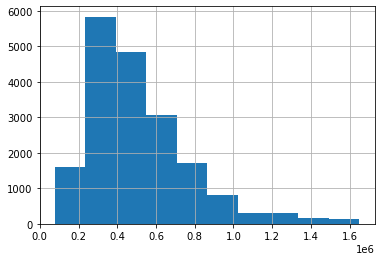

In [33]:
df['price'].hist()

Next, I look at the *sqft_living* predictor.

<AxesSubplot:>

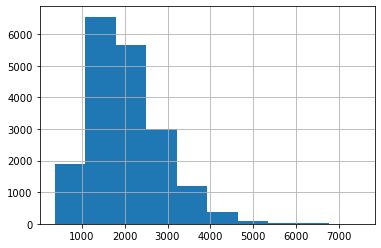

In [34]:
df['sqft_living'].hist()

In [35]:
df['sqft_living'].describe()

count    18803.000000
mean      2033.471999
std        837.690802
min        370.000000
25%       1411.500000
50%       1900.000000
75%       2510.000000
max       7480.000000
Name: sqft_living, dtype: float64

In [36]:
mean_living = df['sqft_living'].mean()
std3_living = 3*df['sqft_living'].std()
print(mean_living - std3_living, mean_living + std3_living)

-479.600405407758 4546.544403705902


The min of *sqft_living* does not fall under 3 standard deviations below the mean. But just by observing the max, it is apparent that at least one entry exceeds 3 standard deviations above the column's mean. I filter out any values exceeding this upper limit. 

In [37]:
upper_living = mean_living + std3_living
df = df[df['sqft_living'] <= upper_living]

<AxesSubplot:>

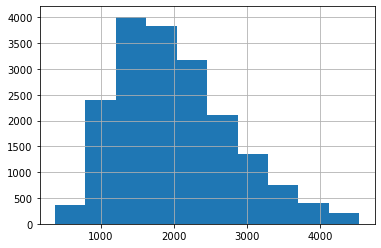

In [38]:
df['sqft_living'].hist()

Next, I look at the *sqft_lot* columns for any outliers.

<AxesSubplot:>

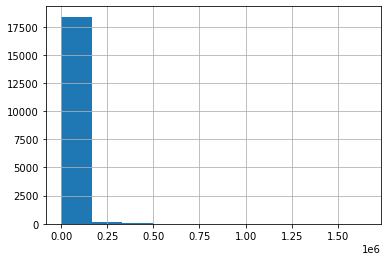

In [39]:
df['sqft_lot'].hist()

In [40]:
df['sqft_lot'].describe()

count    1.863200e+04
mean     1.442871e+04
std      3.869237e+04
min      5.200000e+02
25%      5.000000e+03
50%      7.520000e+03
75%      1.039525e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [41]:
mean_lot = df['sqft_lot'].mean()
std3_lot = 3*df['sqft_lot'].std()
print(mean_lot - std3_lot, mean_lot + std3_lot)

-101648.40775254855 130505.82767526215


Just like with *sqft_living*, the min *sqft_lot* value isn't 3 standard deviations or more below the mean. On the flip side, though, at least the column's max is more than 3 standard deviations above the mean. Similarly to before, I filter out any values that exceed this upper limit.

In [42]:
upper_lot = mean_lot + std3_lot
df = df[df['sqft_lot'] <= upper_lot]

<AxesSubplot:>

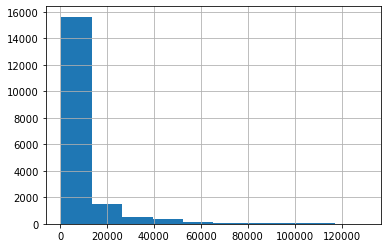

In [43]:
df['sqft_lot'].hist()

Finally, to keep up to date with the dataset, let's see if we still have a sufficient amount of entries (at least 15,000). 

In [44]:
df.count()

id             18344
price          18344
bedrooms       18344
sqft_living    18344
sqft_lot       18344
floors         18344
waterfront     18344
view           18344
condition      18344
yr_built       18344
zipcode        18344
dtype: int64

Now, I update the **df_pred** DataFrame after making the above changes to the main DataFrame **df**. Once this is done, I'm ready to run the new regression model. 

In [45]:
df_pred = df.drop(['price', 'id'], axis=1)

In [46]:
outcome = 'price'
x_cols = df_pred.columns
predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [47]:
model_2 = ols(formula=f, data=df).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     2120.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:58:59   Log-Likelihood:            -2.4779e+05
No. Observations:               18344   AIC:                         4.956e+05
Df Residuals:                   18334   BIC:                         4.957e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    8823.0658   2.72e+06      0.003      0.997   -5.33e+06    5.35e+06
bedrooms    -3.629e+04   1916.261    -18.935      0.000      -4e+04   -3.25e+04
sqft_living   237.4873      2.452     96.858      0.000     232.681     242.293
sqft_lot       -0.8521      0.107     -7.989      0.000      -1.061      -0.643
floors        7.65e+04   2991.009     25.575      0.000    7.06e+04    8.24e+04
waterfront   1.448e+05   2.16e+04      6.719      0.000    1.03e+05    1.87e+05
view         5.358e+04   2128.263     25.176      0.000    4.94e+04    5.78e+04
condition    2.018e+04   2208.811      9.136      0.000    1.58e+04    2.45e+04
yr_built    -1999.5005     59.079    -33.845      0.000   -2115.300   -1883.701
zipcode        39.7169     27.320      1.454      0.146     -13.833      93.266
==============================================================================
Omnibus:                     2808.019   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7182.388
Skew:                           0.856   Prob(JB):                         0.00
Kurtosis:                       5.543   Cond. No.                     2.05e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
data = df.copy()

y = data['price']
X = data.drop(['price', 'id'], axis = 1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [51]:
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

Train MSE: 31685081253.89632
Test MSE: 31511592449.02177
RMSE Train: 178003.03720413402
RMSE Test: 177515.04851426475


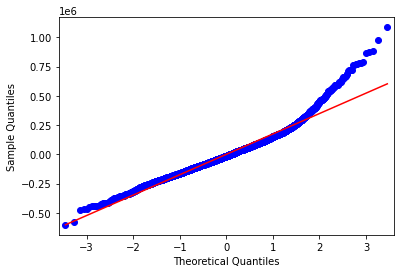

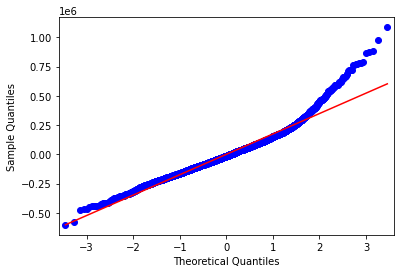

In [52]:
residuals = (y_test - y_hat_test)

sm.qqplot(residuals, line = "r")

Getting rid of the outliers did lower the model's R-squared value from 0.597 to 0.510. On the flip side, though, the RMSE did imporve considerably (~175,000 here vs ~240,000 before). Additionally, the Q-Q Plot indicates that the residuals have become more Normally distributed, though they still have some right skew.

The *zipcode* feature does have a coefficient with a small t-statistic. This does not overly concern me, however, because I will soon get around to encoding this feature, which should eliminate the problem. 

Ultimately, I choose to stick with the changes made here, in the hopes that transforming some of the features will sufficiently improve the R-squared value. 

# Model 3: Transforming Continuous Data

Let's look again at the scatterplots of individual predictors vs. home price:

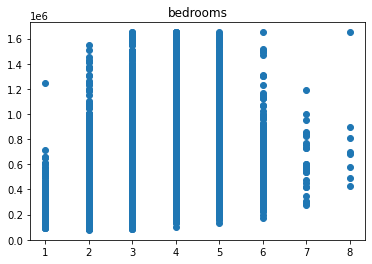

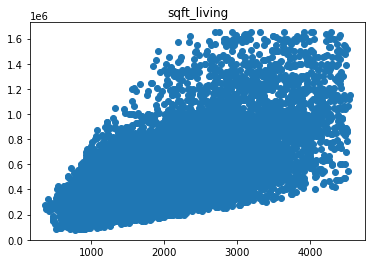

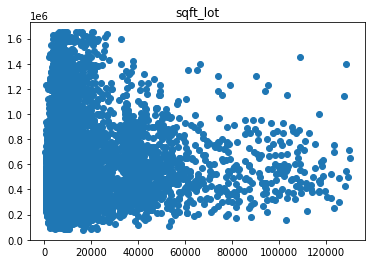

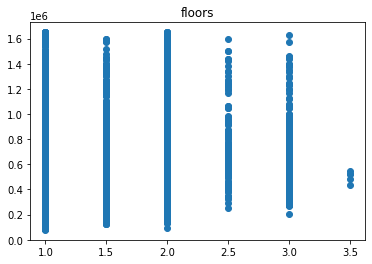

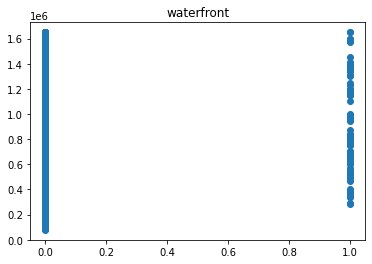

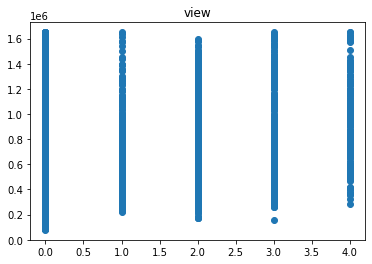

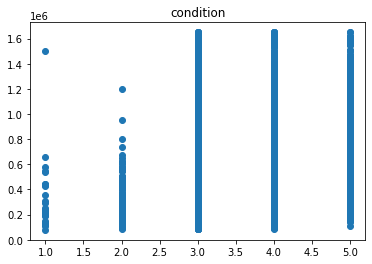

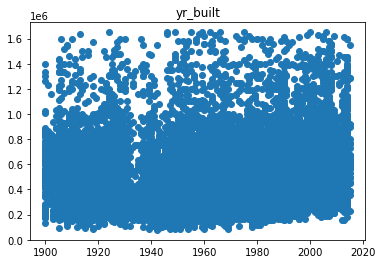

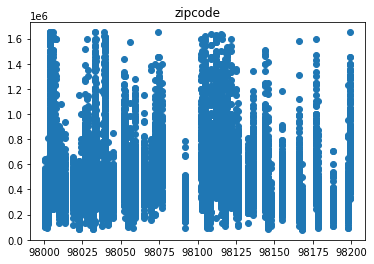

In [53]:
for col in df_pred.columns:
    plt.scatter(df_pred[col], df['price'])
    plt.title(col)
    plt.show()

Here, it is apparent that the two continuous variables in the set of features are the *sqft_living* & *sqft_lot* columns. Both columns' scatterplots have a "cloud-like" appearence with no apparent vertically-aligned clusters.

Next, I take another look at the histograms for the two continuous predictors to see how their distribution looks. 

<AxesSubplot:>

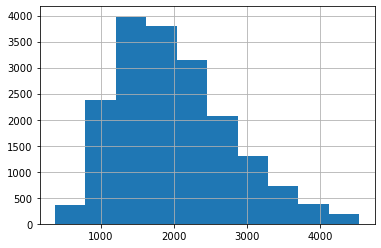

In [54]:
df['sqft_living'].hist()

The *sqft_living* values seem to be distributed fairly normally, with a slight right skew. I determine that the distribution is good enough as is and does not require any transformation.

Next, I inspect the *sqft_lot* distribution. 

<AxesSubplot:>

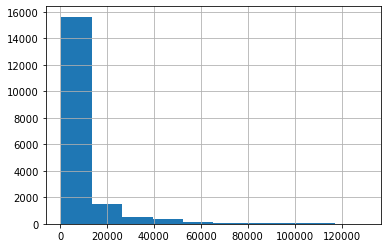

In [55]:
df['sqft_lot'].hist()

This predictor's distribution does not appear Normal at all. Additionally, from using the .describe() method on the column previously, I now know that all of its values are above 0. This makes the column a prime candidate for log-transformation. 

In [56]:
df['sqft_lot'] = np.log(df['sqft_lot'])

<AxesSubplot:>

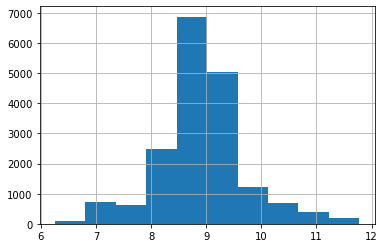

In [57]:
df['sqft_lot'].hist()

The distribution of the column's transformed values is much closer to a Normal one, and should lead to improvements in the next model iteration.

In [58]:
df_pred = df.drop(['price', 'id'], axis=1)

In [59]:
outcome = 'price'
x_cols = df_pred.columns
predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [60]:
model_3 = ols(formula=f, data=df).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     2181.
Date:                Tue, 26 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:38:33   Log-Likelihood:            -2.4765e+05
No. Observations:               18344   AIC:                         4.953e+05
Df Residuals:                   18334   BIC:                         4.954e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.023e+07   2.77e+06      3.689      0.000    4.79e+06    1.57e+07
bedrooms    -3.558e+04   1894.968    -18.775      0.000   -3.93e+04   -3.19e+04
sqft_living   249.7833      2.540     98.357      0.000     244.806     254.761
sqft_lot    -3.752e+04   2057.473    -18.235      0.000   -4.16e+04   -3.35e+04
floors       5.565e+04   3229.210     17.234      0.000    4.93e+04     6.2e+04
waterfront   1.672e+05   2.14e+04      7.799      0.000    1.25e+05    2.09e+05
view         5.346e+04   2112.888     25.302      0.000    4.93e+04    5.76e+04
condition    1.968e+04   2193.067      8.973      0.000    1.54e+04     2.4e+04
yr_built    -2053.5894     58.737    -34.962      0.000   -2168.720   -1938.459
zipcode       -60.0071     27.781     -2.160      0.031    -114.461      -5.553
==============================================================================
Omnibus:                     2850.958   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7557.925
Skew:                           0.856   Prob(JB):                         0.00
Kurtosis:                       5.638   Cond. No.                     2.09e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
data = df.copy()

y = data['price']
X = data.drop(['price', 'id'], axis = 1)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [63]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [64]:
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

Train MSE: 31390905377.63209
Test MSE: 30457358674.554604
RMSE Train: 177174.78764664032
RMSE Test: 174520.367506359


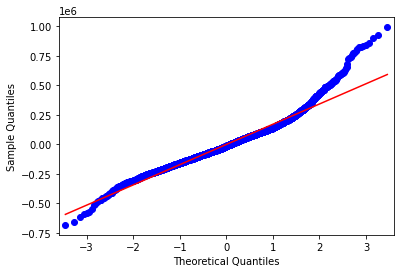

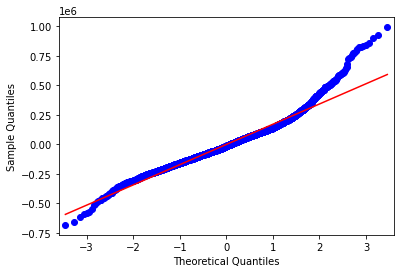

In [65]:
residuals = (y_test - y_hat_test)

sm.qqplot(residuals, line = "r")

This latest model has multiple improvements, but they are relatively subtle. 

The R-squared value increased slightly from 0.510 to 0.517. Additionally, none of the current features' coefficients have low t-scores.

# Model 4: Dealing With Categorical Data

In [66]:
cat = ['bedrooms', 'floors', 'waterfront', 'condition', 'yr_built', 'view', 'zipcode']

In [67]:
df[cat].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18344 entries, 1 to 21596
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedrooms    18344 non-null  int64  
 1   floors      18344 non-null  float64
 2   waterfront  18344 non-null  float64
 3   condition   18344 non-null  int64  
 4   yr_built    18344 non-null  int64  
 5   view        18344 non-null  float64
 6   zipcode     18344 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 1.1 MB


array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>],
       [<AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'view'}>],
       [<AxesSubplot:title={'center':'zipcode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

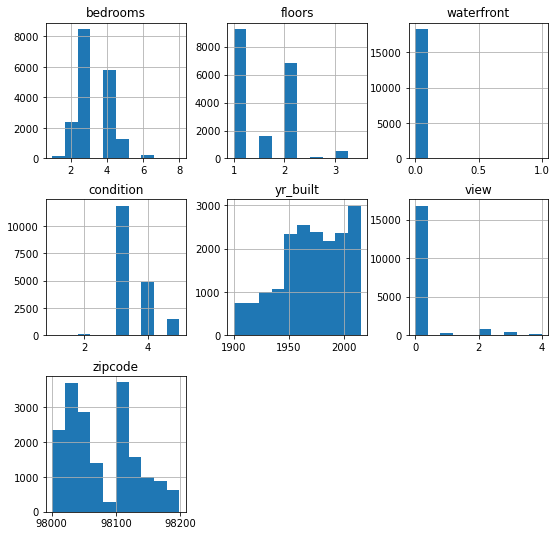

In [68]:
df[cat].hist(figsize=(9,9))

## Binning The 'Year Built' Column Into Decades

In [69]:
decade_bins = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]

In [70]:
df['dec_built'] = pd.cut(df['yr_built'], bins=decade_bins, 
                         right=False)
df['dec_built'] = df['dec_built'].cat.codes

<AxesSubplot:>

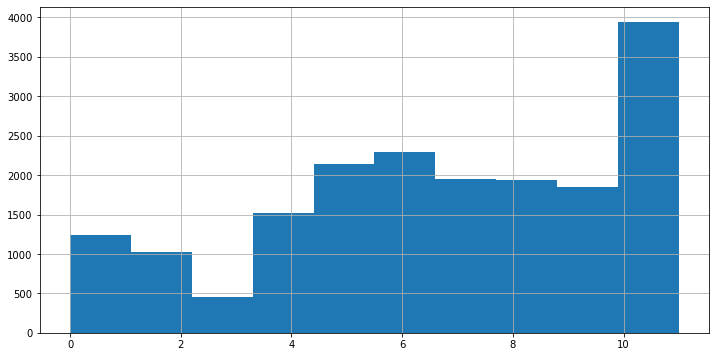

In [71]:
df['dec_built'].hist(figsize=(12,6))

## One Hot Encoding The 'Condition', 'Floors' & 'Zipcode' Columns

In [72]:
cond_dummies = pd.get_dummies(df['condition'], prefix = 'cond', drop_first = True)
floor_dummies = pd.get_dummies(df['floors'], prefix = 'floor', drop_first = True)
zip_dummies = pd.get_dummies(df['zipcode'], prefix = 'zip', drop_first = True)

In [73]:
df_d = pd.concat([df, cond_dummies, floor_dummies, zip_dummies], axis=1)

In [74]:
df_d.columns = df_d.columns.str.replace('.','_')
df_d.drop(['condition', 'floors', 'zipcode', 'yr_built'], axis=1, inplace=True)

In [75]:
df_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18344 entries, 1 to 21596
Data columns (total 86 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           18344 non-null  int64  
 1   price        18344 non-null  float64
 2   bedrooms     18344 non-null  int64  
 3   sqft_living  18344 non-null  int64  
 4   sqft_lot     18344 non-null  float64
 5   waterfront   18344 non-null  float64
 6   view         18344 non-null  float64
 7   dec_built    18344 non-null  int8   
 8   cond_2       18344 non-null  uint8  
 9   cond_3       18344 non-null  uint8  
 10  cond_4       18344 non-null  uint8  
 11  cond_5       18344 non-null  uint8  
 12  floor_1_5    18344 non-null  uint8  
 13  floor_2_0    18344 non-null  uint8  
 14  floor_2_5    18344 non-null  uint8  
 15  floor_3_0    18344 non-null  uint8  
 16  floor_3_5    18344 non-null  uint8  
 17  zip_98002    18344 non-null  uint8  
 18  zip_98003    18344 non-null  uint8  
 19  zip_

In [76]:
df_pred = df_d.drop(['price', 'id'], axis=1)

In [77]:
outcome = 'price'
x_cols = df_pred.columns
predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [78]:
model_4 = ols(formula=f, data=df_d).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     913.3
Date:                Tue, 26 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:38:39   Log-Likelihood:            -2.3921e+05
No. Observations:               18344   AIC:                         4.786e+05
Df Residuals:                   18259   BIC:                         4.792e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.262e+05   2.87e+04    -14.860      0.000   -4.82e+05    -3.7e+05
bedrooms     -1.77e+04   1230.398    -14.384      0.000   -2.01e+04   -1.53e+04
sqft_living   172.8956      1.734     99.716      0.000     169.497     176.294
sqft_lot     3.431e+04   1612.614     21.279      0.000    3.12e+04    3.75e+04
waterfront   2.668e+05   1.39e+04     19.196      0.000     2.4e+05    2.94e+05
view         5.238e+04   1374.963     38.092      0.000    4.97e+04    5.51e+04
dec_built    2139.7678    474.287      4.512      0.000    1210.121    3069.415
cond_2       4.679e+04   2.47e+04      1.892      0.059   -1696.092    9.53e+04
cond_3       7.875e+04    2.3e+04      3.429      0.001    3.37e+04    1.24e+05
cond_4       8.822e+04    2.3e+04      3.841      0.000    4.32e+04    1.33e+05
cond_5       1.283e+05   2.31e+04      5.554      0.000     8.3e+04    1.74e+05
floor_1_5    1.992e+04   3278.741      6.076      0.000    1.35e+04    2.63e+04
floor_2_0    3.507e+04   2466.754     14.218      0.000    3.02e+04    3.99e+04
floor_2_5    6.819e+04    1.1e+04      6.212      0.000    4.67e+04    8.97e+04
floor_3_0    1.448e+04   6066.645      2.386      0.017    2584.910    2.64e+04
floor_3_5    -3.58e+04   5.02e+04     -0.714      0.475   -1.34e+05    6.25e+04
zip_98002    2.027e+04   1.05e+04      1.939      0.053    -220.427    4.08e+04
zip_98003    1.565e+04   9385.583      1.667      0.095   -2747.546     3.4e+04
zip_98004    6.867e+05   1.01e+04     68.312      0.000    6.67e+05    7.06e+05
zip_98005    3.803e+05   1.12e+04     34.030      0.000    3.58e+05    4.02e+05
zip_98006    3.303e+05   8522.765     38.760      0.000    3.14e+05    3.47e+05
zip_98007     3.08e+05    1.2e+04     25.713      0.000    2.85e+05    3.31e+05
zip_98008    2.838e+05   9510.167     29.845      0.000    2.65e+05    3.02e+05
zip_98010    6.759e+04   1.46e+04      4.633      0.000     3.9e+04    9.62e+04
zip_98011    1.584e+05   1.06e+04     14.999      0.000    1.38e+05    1.79e+05
zip_98014    7.741e+04   1.39e+04      5.579      0.000    5.02e+04    1.05e+05
zip_98019     8.39e+04   1.11e+04      7.568      0.000    6.22e+04    1.06e+05
zip_98022   -6236.4177   1.05e+04     -0.593      0.553   -2.68e+04    1.44e+04
zip_98023     217.0503   8200.151      0.026      0.979   -1.59e+04    1.63e+04
zip_98024    1.307e+05   1.73e+04      7.547      0.000    9.68e+04    1.65e+05
zip_98027    2.046e+05   8663.487     23.621      0.000    1.88e+05    2.22e+05
zip_98028    1.476e+05   9378.909     15.737      0.000    1.29e+05    1.66e+05
zip_98029    2.645e+05   9140.670     28.939      0.000    2.47e+05    2.82e+05
zip_98030     1.61e+04   9630.446      1.672      0.095   -2776.273     3.5e+04
zip_98031    2.726e+04   9504.111      2.869      0.004    8635.701    4.59e+04
zip_98032    1.475e+04   1.22e+04      1.20

The sizable jump in R-squared value is very encouraging, but before I proceed with the rest of modeling, I observe the t-scores (and their associated p-values) for the predictor coefficients. 

A few of the p-values for dummy variable coefficients exceed what most would consider an acceptable cutoff of p=0.05. Consequently, I drop these dummy columns before re-running the model. 

In [79]:
high_t_score = ['cond_2','floor_3_5','zip_98002','zip_98003','zip_98022','zip_98023','zip_98030','zip_98032','zip_98092']
df_d.drop(high_t_score, axis=1, inplace=True)

In [80]:
df_pred = df_d.drop(['price', 'id'], axis=1)

In [81]:
outcome = 'price'
x_cols = df_pred.columns
predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [82]:
model_4 = ols(formula=f, data=df_d).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1022.
Date:                Tue, 26 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:38:42   Log-Likelihood:            -2.3921e+05
No. Observations:               18344   AIC:                         4.786e+05
Df Residuals:                   18268   BIC:                         4.792e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.766e+05   1.81e+04    -20.833      0.000   -4.12e+05   -3.41e+05
bedrooms    -1.759e+04   1229.955    -14.298      0.000      -2e+04   -1.52e+04
sqft_living   172.9268      1.732     99.846      0.000     169.532     176.322
sqft_lot     3.384e+04   1603.614     21.103      0.000    3.07e+04     3.7e+04
waterfront   2.663e+05   1.39e+04     19.170      0.000    2.39e+05    2.94e+05
view          5.23e+04   1373.036     38.088      0.000    4.96e+04     5.5e+04
dec_built    2060.9391    472.837      4.359      0.000    1134.135    2987.743
cond_3       3.916e+04   8859.587      4.420      0.000    2.18e+04    5.65e+04
cond_4       4.877e+04   8895.471      5.482      0.000    3.13e+04    6.62e+04
cond_5       8.858e+04   9253.223      9.573      0.000    7.04e+04    1.07e+05
floor_1_5    1.969e+04   3275.897      6.011      0.000    1.33e+04    2.61e+04
floor_2_0    3.494e+04   2459.178     14.206      0.000    3.01e+04    3.98e+04
floor_2_5    6.792e+04    1.1e+04      6.188      0.000    4.64e+04    8.94e+04
floor_3_0    1.449e+04   6058.978      2.392      0.017    2617.566    2.64e+04
zip_98004    6.809e+05   8269.769     82.332      0.000    6.65e+05    6.97e+05
zip_98005    3.749e+05   9610.396     39.012      0.000    3.56e+05    3.94e+05
zip_98006    3.249e+05   6323.602     51.375      0.000    3.12e+05    3.37e+05
zip_98007    3.023e+05   1.05e+04     28.709      0.000    2.82e+05    3.23e+05
zip_98008    2.781e+05   7594.416     36.618      0.000    2.63e+05    2.93e+05
zip_98010    6.235e+04   1.34e+04      4.637      0.000     3.6e+04    8.87e+04
zip_98011    1.529e+05   8896.667     17.183      0.000    1.35e+05     1.7e+05
zip_98014    7.245e+04   1.27e+04      5.714      0.000    4.76e+04    9.73e+04
zip_98019    7.868e+04   9533.428      8.254      0.000       6e+04    9.74e+04
zip_98024    1.255e+05   1.64e+04      7.663      0.000    9.34e+04    1.58e+05
zip_98027    1.992e+05   6535.887     30.485      0.000    1.86e+05    2.12e+05
zip_98028    1.419e+05   7455.282     19.036      0.000    1.27e+05    1.57e+05
zip_98029    2.589e+05   7147.592     36.226      0.000    2.45e+05    2.73e+05
zip_98031     2.17e+04   7609.921      2.852      0.004    6783.985    3.66e+04
zip_98033    3.843e+05   6453.456     59.546      0.000    3.72e+05    3.97e+05
zip_98034    2.114e+05   5730.989     36.890      0.000       2e+05    2.23e+05
zip_98038    3.421e+04   5660.351      6.045      0.000    2.31e+04    4.53e+04
zip_98039    8.734e+05   2.65e+04     32.974      0.000    8.21e+05    9.25e+05
zip_98040     5.48e+05   8284.206     66.152      0.000    5.32e+05    5.64e+05
zip_98042    1.081e+04   5726.031      1.888      0.059    -410.653     2.2e+04
zip_98045    9.682e+04   9034.875     10.716      0.000    7.91e+04    1.15e+05
zip_98052    2.838e+05   5613.950     50.54

A couple more zipcode dummy columns have coefficients with p-values over 0.05. I drop these last columns before finishing my model. 

In [83]:
df_d.drop(['zip_98042','zip_98070'], axis=1, inplace=True)

In [84]:
df_pred = df_d.drop(['price', 'id'], axis=1)

In [85]:
outcome = 'price'
x_cols = df_pred.columns
predictors = '+'.join(x_cols)

f = outcome + '~' + predictors

In [86]:
model_4 = ols(formula=f, data=df_d).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1050.
Date:                Tue, 26 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:38:44   Log-Likelihood:            -2.3922e+05
No. Observations:               18344   AIC:                         4.786e+05
Df Residuals:                   18270   BIC:                         4.792e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.773e+05    1.8e+04    -20.903      0.000   -4.13e+05   -3.42e+05
bedrooms    -1.768e+04   1229.112    -14.384      0.000   -2.01e+04   -1.53e+04
sqft_living   172.7867      1.731     99.812      0.000     169.394     176.180
sqft_lot     3.426e+04   1592.575     21.513      0.000    3.11e+04    3.74e+04
waterfront   2.711e+05   1.36e+04     19.878      0.000    2.44e+05    2.98e+05
view         5.234e+04   1371.950     38.147      0.000    4.96e+04     5.5e+04
dec_built    2115.1629    472.322      4.478      0.000    1189.367    3040.959
cond_3       3.869e+04   8858.449      4.367      0.000    2.13e+04    5.61e+04
cond_4       4.846e+04   8895.258      5.448      0.000     3.1e+04    6.59e+04
cond_5       8.855e+04   9253.219      9.569      0.000    7.04e+04    1.07e+05
floor_1_5    1.984e+04   3275.290      6.056      0.000    1.34e+04    2.63e+04
floor_2_0    3.521e+04   2457.065     14.332      0.000    3.04e+04       4e+04
floor_2_5    6.827e+04    1.1e+04      6.220      0.000    4.68e+04    8.98e+04
floor_3_0     1.48e+04   6056.794      2.444      0.015    2931.210    2.67e+04
zip_98004    6.782e+05   8194.548     82.766      0.000    6.62e+05    6.94e+05
zip_98005    3.722e+05   9542.005     39.004      0.000    3.53e+05    3.91e+05
zip_98006    3.221e+05   6216.421     51.814      0.000     3.1e+05    3.34e+05
zip_98007    2.997e+05   1.05e+04     28.621      0.000    2.79e+05     3.2e+05
zip_98008    2.755e+05   7514.071     36.661      0.000    2.61e+05     2.9e+05
zip_98010    5.932e+04   1.34e+04      4.429      0.000    3.31e+04    8.56e+04
zip_98011    1.502e+05   8824.166     17.021      0.000    1.33e+05    1.67e+05
zip_98014    6.933e+04   1.26e+04      5.495      0.000    4.46e+04    9.41e+04
zip_98019    7.583e+04   9458.675      8.016      0.000    5.73e+04    9.44e+04
zip_98024    1.225e+05   1.63e+04      7.500      0.000    9.05e+04    1.55e+05
zip_98027    1.964e+05   6428.795     30.556      0.000    1.84e+05    2.09e+05
zip_98028    1.392e+05   7367.760     18.894      0.000    1.25e+05    1.54e+05
zip_98029    2.563e+05   7054.510     36.330      0.000    2.42e+05     2.7e+05
zip_98031    1.897e+04   7521.266      2.522      0.012    4226.003    3.37e+04
zip_98033    3.816e+05   6351.616     60.078      0.000    3.69e+05    3.94e+05
zip_98034    2.088e+05   5620.466     37.146      0.000    1.98e+05     2.2e+05
zip_98038    3.144e+04   5534.944      5.680      0.000    2.06e+04    4.23e+04
zip_98039    8.707e+05   2.65e+04     32.899      0.000    8.19e+05    9.23e+05
zip_98040    5.453e+05   8204.775     66.458      0.000    5.29e+05    5.61e+05
zip_98045    9.383e+04   8952.385     10.481      0.000    7.63e+04    1.11e+05
zip_98052    2.811e+05   5495.057     51.150      0.000     2.7e+05    2.92e+05
zip_98053      2.4e+05   6656.247     36.06

In [87]:
data = df_d.copy()

y = data['price']
X = data.drop(['price', 'id'], axis = 1)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [89]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [90]:
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

Train MSE: 12376772008.866838
Test MSE: 12705384692.355526
RMSE Train: 111250.94160889983
RMSE Test: 112718.16487308302


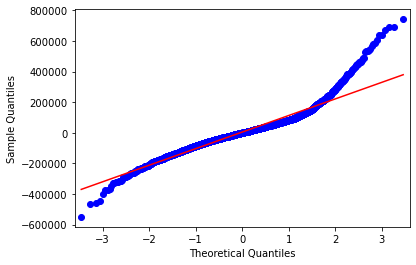

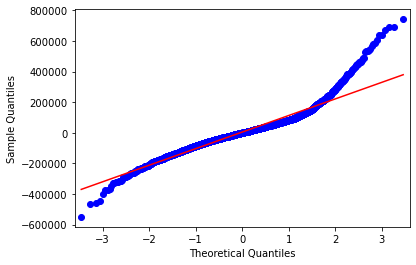

In [91]:
residuals = (y_test - y_hat_test)

sm.qqplot(residuals, line = "r")

# Final Model Evaluation

My final regression model, built to predict the price of a house in King County, can be evaluated using the following metrics. 

* **R-squared = 0.808** : This value indicates that my model explains 80.8% of the variation in home prices from their mean value. 

* **Root Mean Square Error (Using Test Data) = 114522** : On average, my model's predicted price is +/- $114,522 from the home's actual value.

* **Q-Q Plot (see above)** : From the plot, it seems that the residuals produced by my model have a relatively Normal distribution within 2 standard deviations of the mean. However, there is some skew, especially towards the right. In other words, my model is generally best at predicting the prices of homes that cost up to about $1,009,014.

# Conclusions

My analysis leads to the following advice for any prospective first time home buyer in King County, WA:

* Clients looking to save on their home purchase could start by looking in these zip codes: 98198, 98188, 98031, 98038, 98178, 98168 & 98058. 
* Conversely, clients looking to make a bigger investment could start by looking in these zip codes: 98039, 98004, 98119, 98112, 98109, 98102 & 98040. 
* Clients looking to save money should consider the home's condition grade, as it seems to have a sizable impact on price. Even going from an average grade to a high grade can increase a home's price significantly. 
* As expected, there seems to be significant correlation between a home's square footage & its price.

# Future Work

Given more time, I would look at the features I had to initially omit. This would involve using the *lat* & *long* columns to further inspect the impact of specific locations (beyond zip codes) on price. Additionally, I would look at the *sqft_living15* & *sqft_lot15* columns to get insight on what neighborhoods are most expensive to live in and the overall impact of comparative size of neighbors' homes. 